This project is to analize diferent functionalities and modules from python.
The dataset was obtained from Buenos Aires City govermet public records. The dataset selected for this proyect it's about calls made to Domesctic Violence Hotline, where its determined the next step, for example, send cops to the location or provide legal advise.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import seaborn as sns
import numpy as np

import LoadingData as LD
import ExplorationDataAnalysis as EDA
import MachineLearning as ML

from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LassoCV, LassoLarsCV, LassoLarsIC
from sklearn.linear_model import Lasso
from sklearn.linear_model import lasso_path
from sklearn import preprocessing

In [3]:
df, lavf_all_new = LD.ReadData()
df.shape

At first dataset was (23420, 16) of raw information, missing data and typing mistakes. After Exploration Data Analysis, the final size is 20% from original (4265, 19).


(4256, 19)

## Boxplot victims age by gender

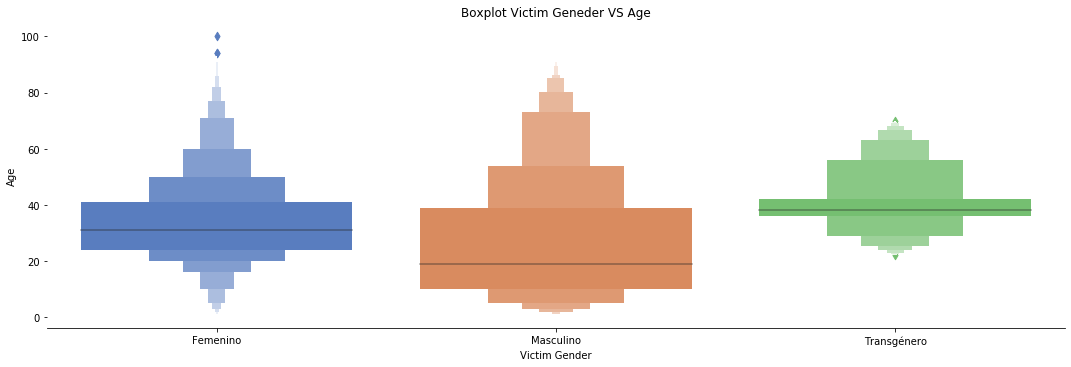

In [4]:
EDA.Graphs.BoxplotGender(X = df)

## Summary victims age

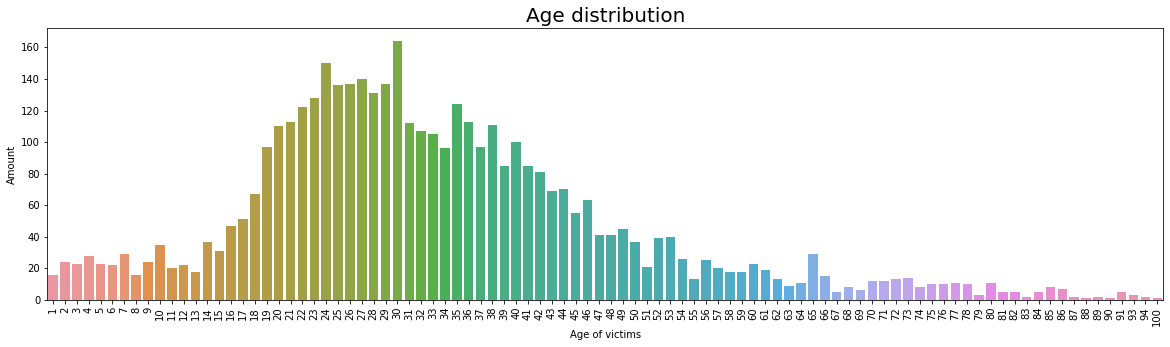

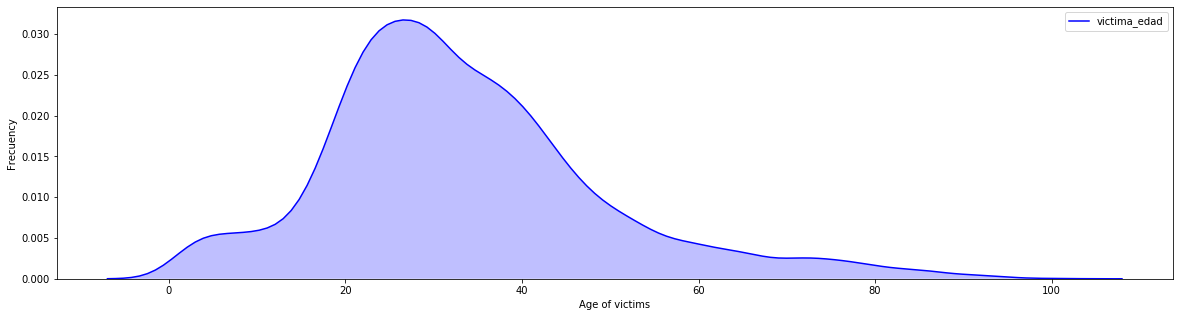

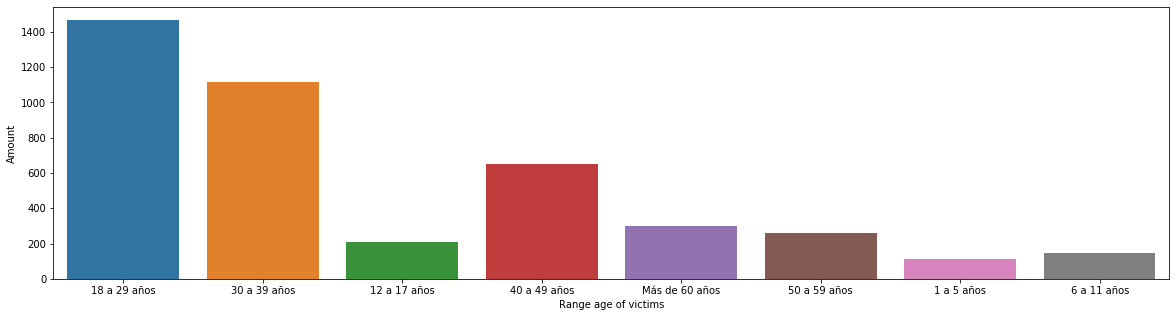

In [5]:
EDA.Graphs.AgePlot(X = df)

## Distribution of calls throughout the day for the final dataset pre training models


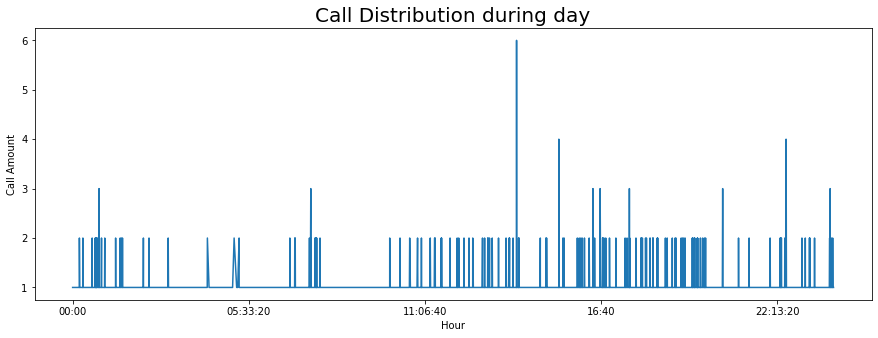

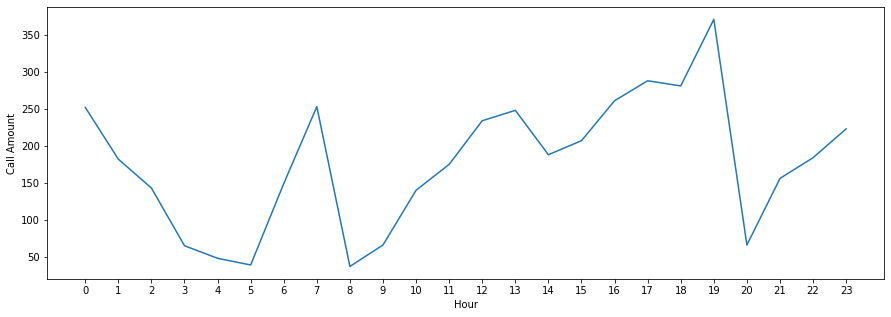

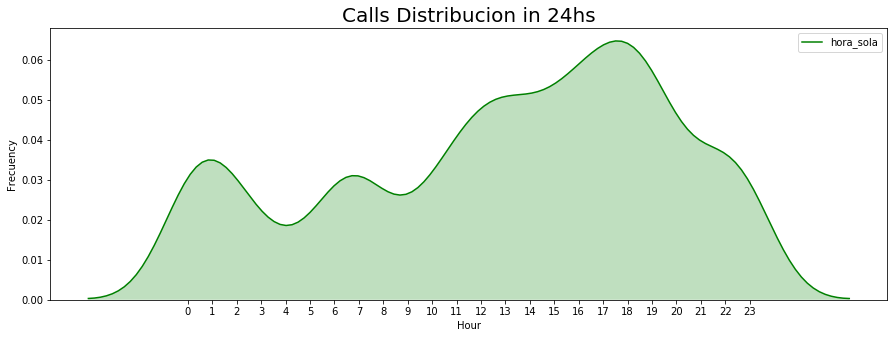

In [6]:
EDA.Graphs.TimePlot(X = df)

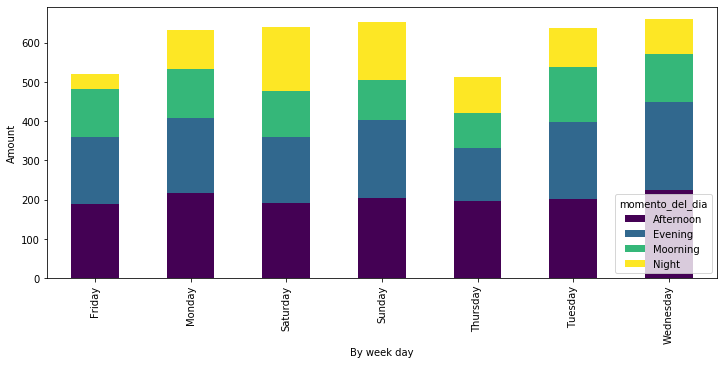

In [7]:
EDA.Graphs.WeekdayPlot(X = df)

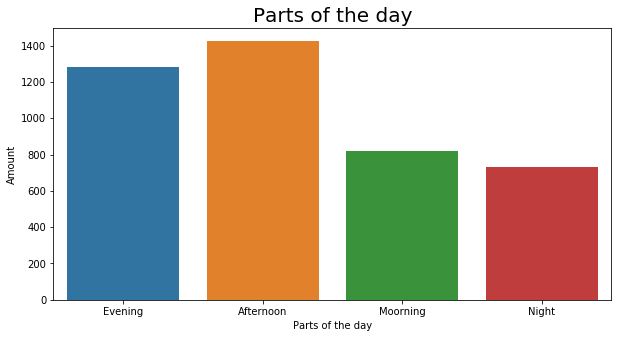

In [8]:
EDA.Graphs.DaytimePlot(X = df)

### With the dataset explored, cleaned and normalized, for Feature Selection process it will be necessary to apply LabelEncoders to the string type fields

*CORREGIR TEXTO:* Note the remarkable inversely linear relationship between the gender of the victim and the gender of the aggressor of [-0.39]


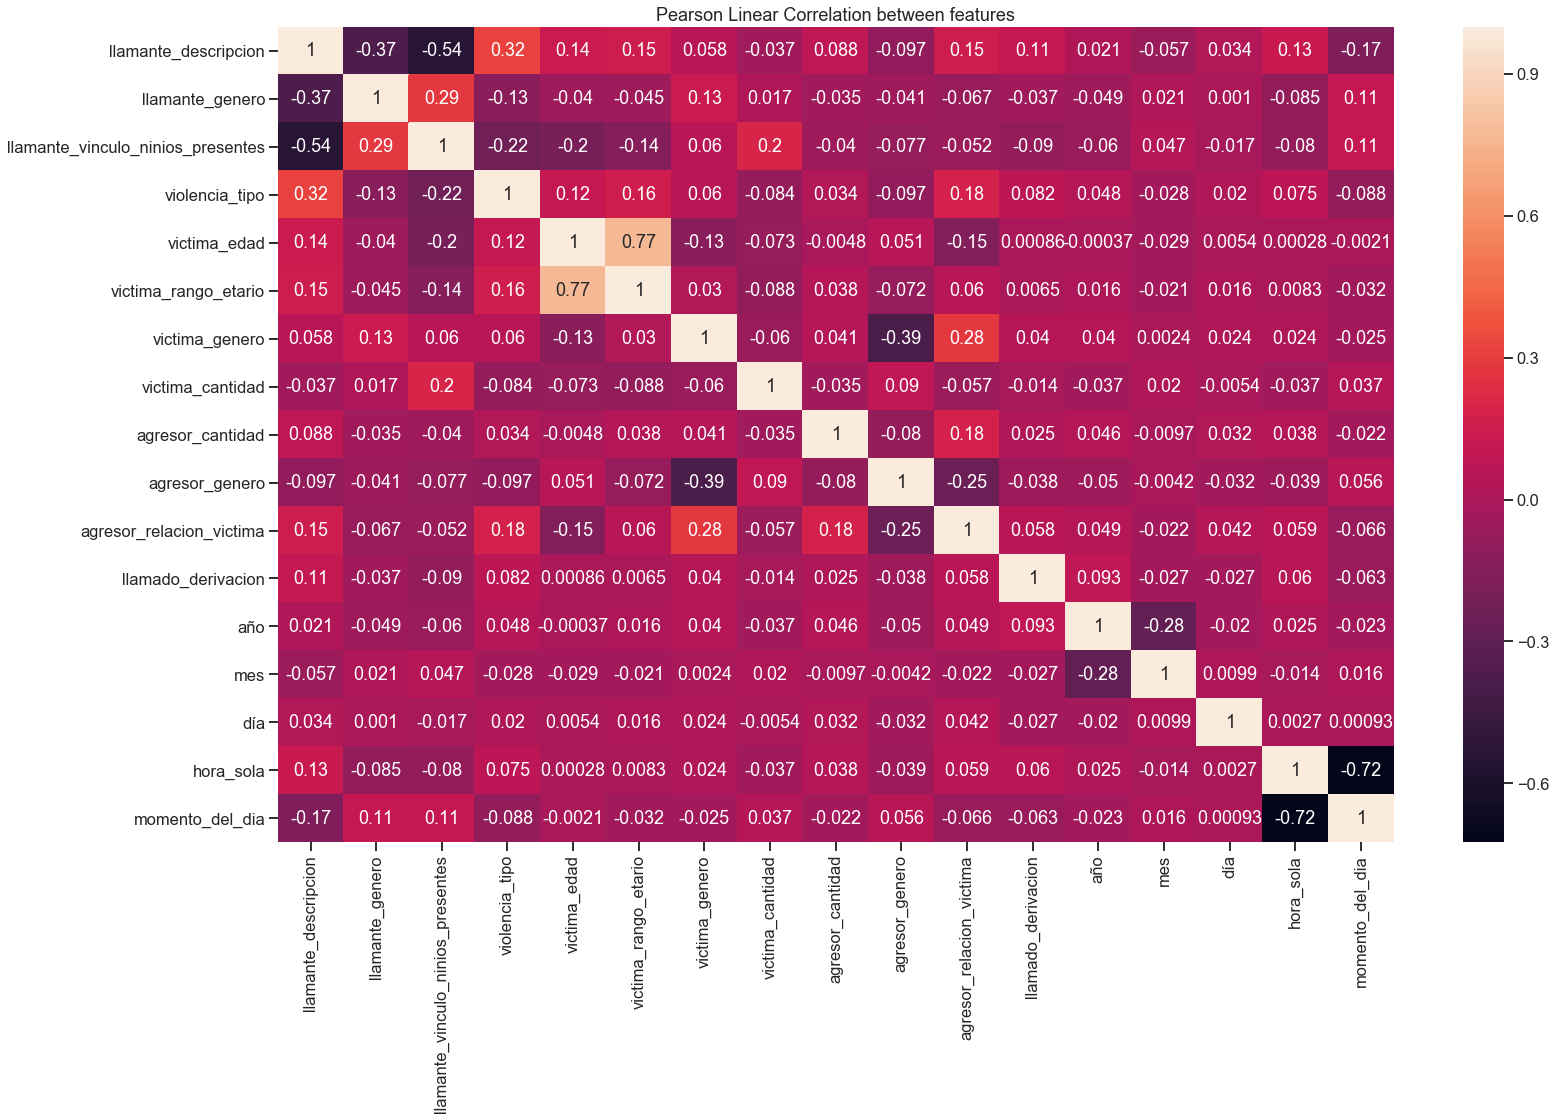

In [9]:
dfe = ML.LabelEncoding(X = df)
EDA.Graphs.PearsonCorrelation(X = dfe)

###  Next step is to predict the "victim_age". Different Feature Selection methods are going to be applied for the diferent models

Data Frame Enconded will be split on train/test and standerized.
Feature Selection Methods:  
- NFS: No Feature Selection
- THR: Threshole
- LAS: Lasso

In [10]:
#Split
x =dfe.drop(['victima_edad'], axis=1)
y = dfe.iloc[:,4]
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.3, random_state=4)

scaler = preprocessing.StandardScaler().fit(xtrain)
xtrain_scal = scaler.transform(xtrain)
xtest_scal = scaler.transform(xtest)

#Treshole
thresh = 0.5
xtrain_scal_var = xtrain.iloc[:,(np.std(xtrain)>np.quantile(np.std(xtrain), thresh)).values]
xtest_scal_var = xtest.iloc[:,(np.std(xtrain)>np.quantile(np.std(xtrain), thresh)).values]
x_threshold = x.iloc[:,(np.std(xtrain)>np.quantile(np.std(xtrain), thresh)).values]
threshold_cols = np.where(x_threshold.columns)
#Lasso
lasso_featsel = Lasso(alpha = 0.1)
lasso_featsel.fit(xtrain_scal,ytrain)
lasso_cols = lasso_featsel.coef_ != 0
x_lasso = x.iloc[:, lasso_cols]
xtrain_scal_lasso = xtrain_scal[:, lasso_cols]
xtest_scal_lasso = xtest_scal[:, lasso_cols]

#Result from Feature Selection with Threshole and Lasso
EDA.Text.FeatureSelection(T=x_threshold,L=x_lasso)

The Features selected by THRESHOLD method [8]
Index(['llamante_descripcion', 'llamante_vinculo_ninios_presentes',
       'victima_rango_etario', 'agresor_relacion_victima',
       'llamado_derivacion', 'mes', 'día', 'hora_sola'],
      dtype='object')

The Features selected by LASSO method [12]
Index(['llamante_descripcion', 'llamante_genero',
       'llamante_vinculo_ninios_presentes', 'victima_rango_etario',
       'victima_genero', 'agresor_cantidad', 'agresor_genero',
       'agresor_relacion_victima', 'año', 'mes', 'momento_del_dia'],
      dtype='object')



#### Different regression models will be tested, with and without Feature Selection methods

## - LR: Logistic Regression -

In [11]:
ypred_lr_sfs, ypred_lr_var, ypred_lr_lasso, LR_Stats = ML.LR(xtrain_scal=xtrain_scal, 
      xtest_scal=xtest_scal, 
      xtrain_scal_var=xtrain_scal_var, 
      xtest_scal_var=xtest_scal_var,
      xtrain_scal_lasso=xtrain_scal_lasso,
      xtest_scal_lasso=xtest_scal_lasso,                                             
      ytrain=ytrain, 
      ytest=ytest, 
      lasso_cols=lasso_cols)

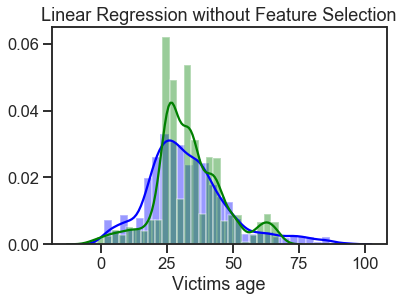

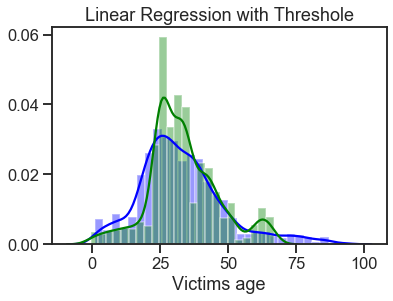

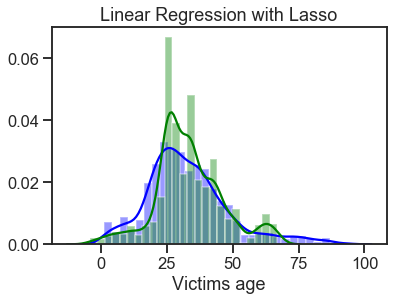

In [12]:
EDA.Graphs.LRdistplotSFS(ytest=ytest, ypred_lr_sfs=ypred_lr_sfs)
EDA.Graphs.LRdistplotTr(ytest=ytest, ypred_lr_var=ypred_lr_var)
EDA.Graphs.LRdistplotLs(ytest=ytest, ypred_lr_lasso=ypred_lr_lasso)

## - KNN: K-Nearest-Neighbor -

In [13]:
ypred_knn_sfs, ypred_knn_var, ypred_knn_lasso, KNN_Stats = ML.KNN(xtrain_scal,
        xtest_scal,
        xtrain_scal_var,
        xtest_scal_var,
        xtrain_scal_lasso,
        xtest_scal_lasso,                                               
        ytrain,
        ytest)


Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    4.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    2.8s finished


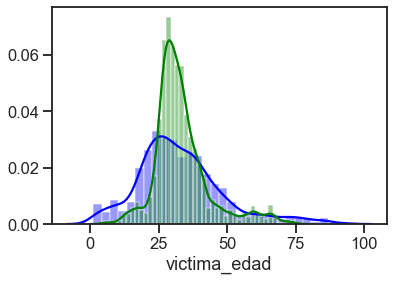

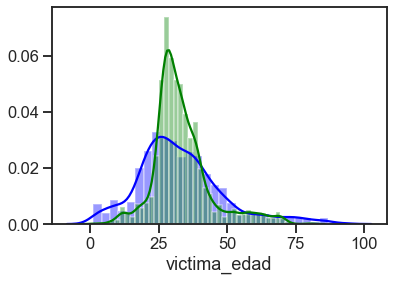

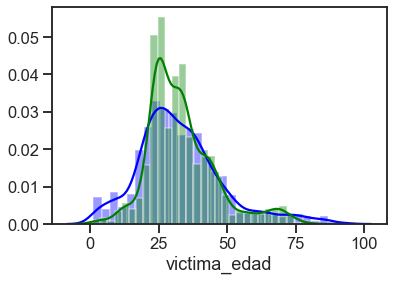

In [14]:
EDA.Graphs.KNNdistplotSFS(ytest=ytest, ypred_knn_sfs=ypred_knn_sfs)
EDA.Graphs.KNNdistplotTh(ytest=ytest, ypred_knn_var=ypred_knn_var)
EDA.Graphs.KNNdistplotLs(ytest=ytest ,ypred_knn_lasso=ypred_knn_lasso)

## - SVR: Support Vector Machines -

In [15]:
ypred_svr_l_sfs, ypred_svr_l_var, ypred_svr_l_lasso, SVR_Stats = ML.KNN(xtrain_scal,
        xtest_scal,
        xtrain_scal_var,
        xtest_scal_var,
        xtrain_scal_lasso,
        xtest_scal_lasso,                                               
        ytrain,
        ytest)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    4.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    2.9s finished


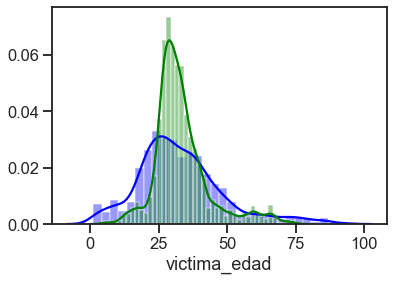

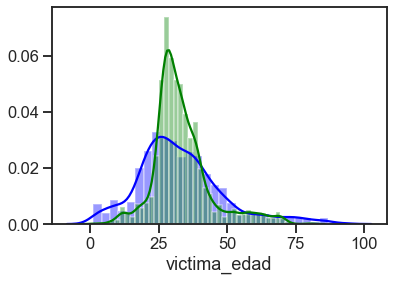

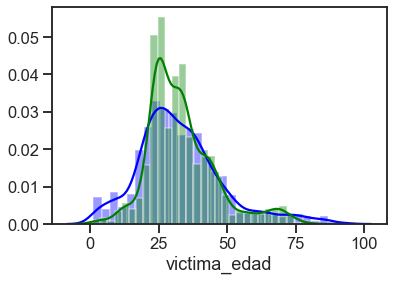

In [16]:
EDA.Graphs.SRVdistplotSFS(ytest=ytest, ypred_svr_l_sfs=ypred_svr_l_sfs)
EDA.Graphs.SRVdistplotTh(ytest=ytest, ypred_svr_l_var=ypred_svr_l_var)
EDA.Graphs.SRVdistplotLs(ytest=ytest, ypred_svr_l_lasso=ypred_svr_l_lasso)

## - GS: Gaussian -

In [17]:
ypred_svr_g_sfs, ypred_svr_g_var, ypred_svr_g_lasso, GS_Stats = ML.Gauss(xtrain_scal,
        xtest_scal,
        xtrain_scal_var,
        xtest_scal_var,
        xtrain_scal_lasso,
        xtest_scal_lasso,
        ytrain,
        ytest)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:   28.0s finished


Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:   27.9s finished


Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:   16.7s finished


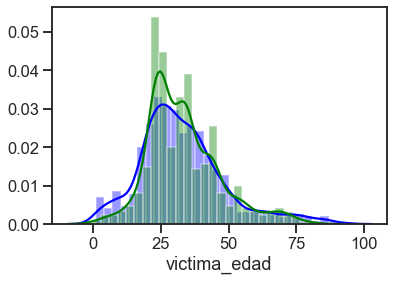

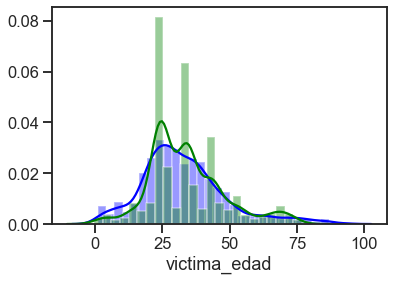

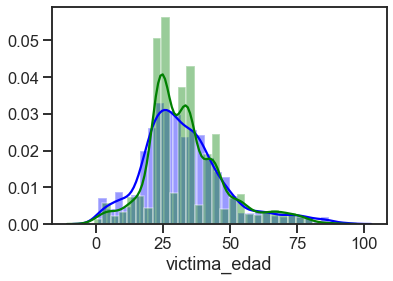

In [18]:
EDA.Graphs.GSdistplotSFS(ytest=ytest, ypred_svr_g_sfs=ypred_svr_g_sfs)
EDA.Graphs.GSdistplotTh(ytest=ytest, ypred_svr_g_var=ypred_svr_g_var)
EDA.Graphs.GSdistplotLs(ytest=ytest, ypred_svr_g_lasso=ypred_svr_g_lasso)

## -- Comparison between models --
NFS: No Feature Selection
THR: Threshole
LAS: Lasso

In [19]:
EDA.Text.Comparison(LR_Stats, KNN_Stats, SVR_Stats, GS_Stats)


,RMSE,MSE,MAE
LR-NFS,9.814111,96.316772,5.528623
LR-THR,9.958438,99.170482,5.514818
LR-LAS,9.822689,96.485222,5.535891
KNN-NFS,11.003127,121.068812,7.314538
KNN-THR,10.758211,115.739099,6.997203
KNN-LAS,9.638723,92.904974,5.845979
SVR-NFS,11.003127,121.068812,7.314538
SVR-THR,10.758211,115.739099,6.997203
SVR-LAS,9.638723,92.904974,5.845979
SVR-G-NFS,9.107487,82.946319,5.209680


The models selected to advance with the prediction of age are:
- KNN with Lasso
- Gaussian SVR without Feature Selection
Despite not having the best performance according to their errors, these models were chosen because Graphically their curve and histogram are the most faithful to the test one

## EDA to obtain the No_Data to be used with the generated models

There are 1827 lines whose 'Victim Age' contains No_Data and all the other features contains information.
This represents a 42% compared with the dataset used to train the regression models.
From the original data set, it is almost 20% from all No_Data samples. After predicting the age using the selected models, the amount of samples with all features completed, will encrease from 19% used to approximately 27%

In [20]:
age_no_data = LD.AgeNoData(lavf_all_new)
x_nodata_scal = ML.AgeEncoding(age_no_data, xtrain)


C:\Users\60068779\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


### KNN Lasso - [Mas representativo en distribucion e histograma]

In [21]:
df_knn = ML.KNN_Lasso(x_nodata_scal,lasso_cols, xtrain_scal_lasso,ytrain, age_no_data, df)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    3.1s finished


### SVR Gaussiano Threshold - [El de menor error]

In [22]:
df_svrg = ML.SVR_G_Threshole (x_nodata_scal, threshold_cols, xtrain_scal_var, ytrain, age_no_data, df)
np.shape(df_svrg)
#Buscar error en fórmula de SVR Gaussiano. 

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:   29.0s finished


(6083, 19)

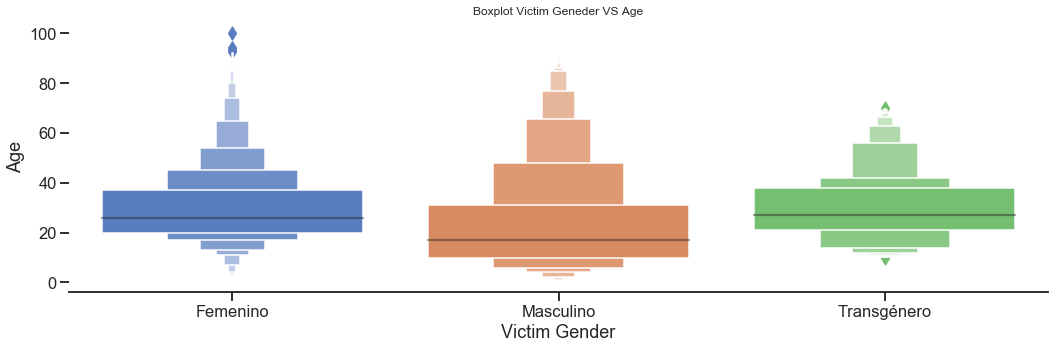

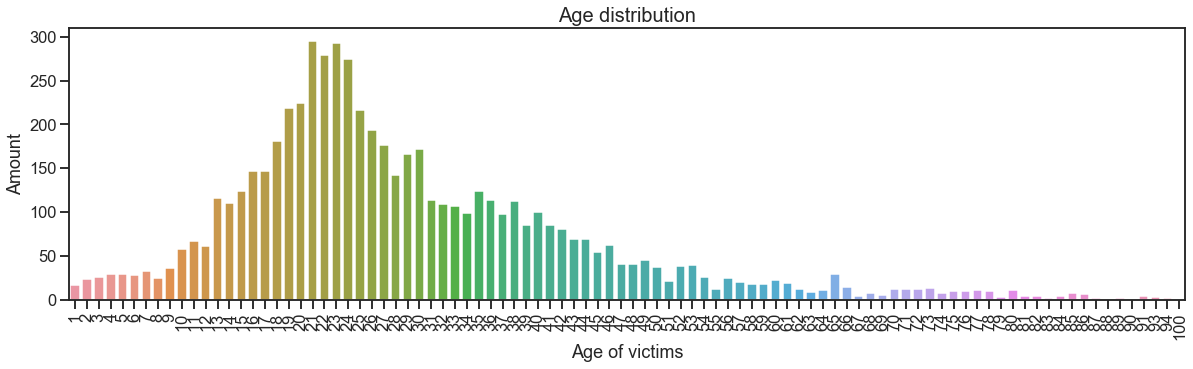

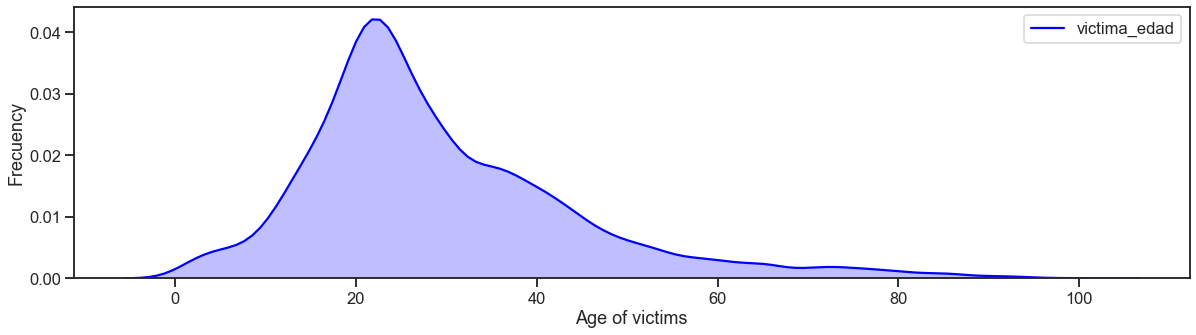

In [23]:
EDA.Graphs.BoxplotGender(X = df_knn)
EDA.Graphs.AgePlot2(X = df_knn)


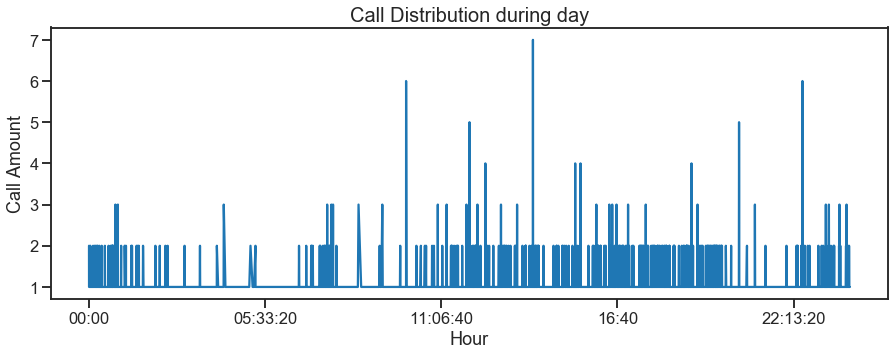

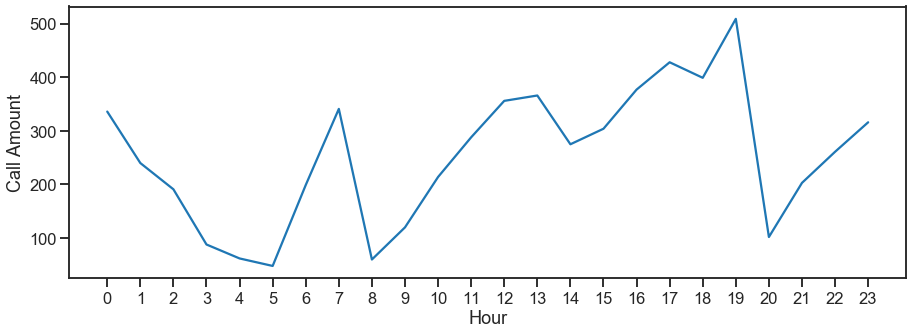

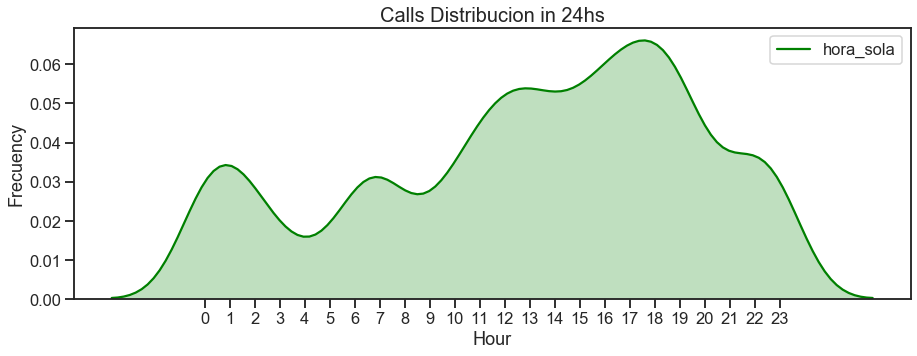

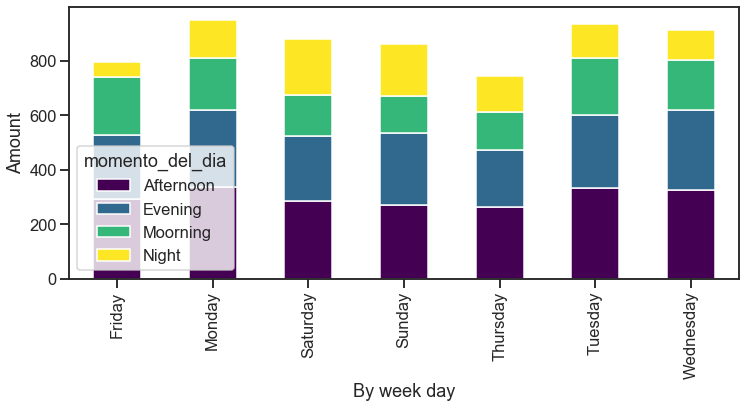

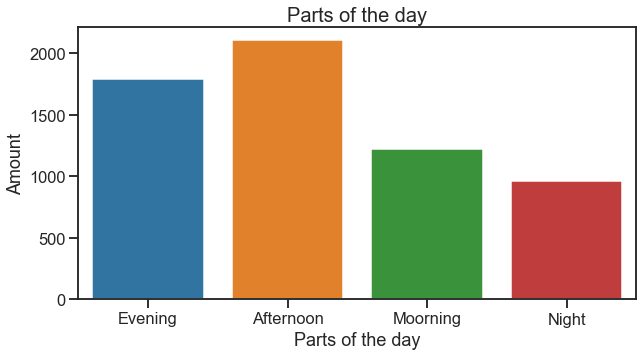

In [24]:
EDA.Graphs.TimePlot(X = df_knn)
EDA.Graphs.WeekdayPlot(X = df_knn)
EDA.Graphs.DaytimePlot(X = df_knn)

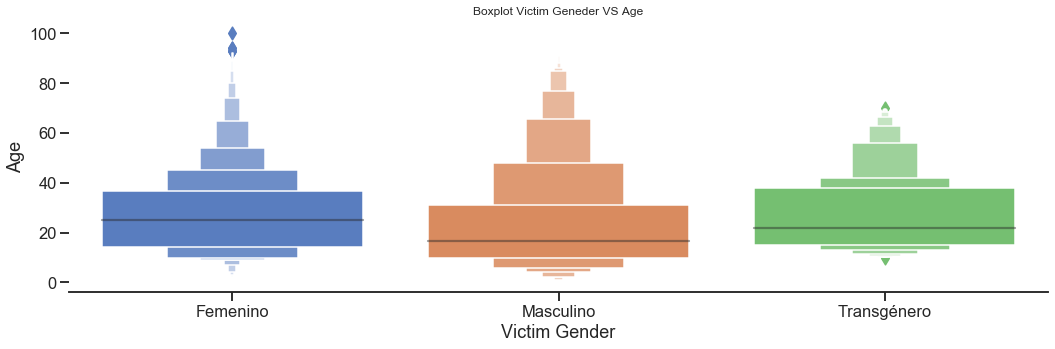

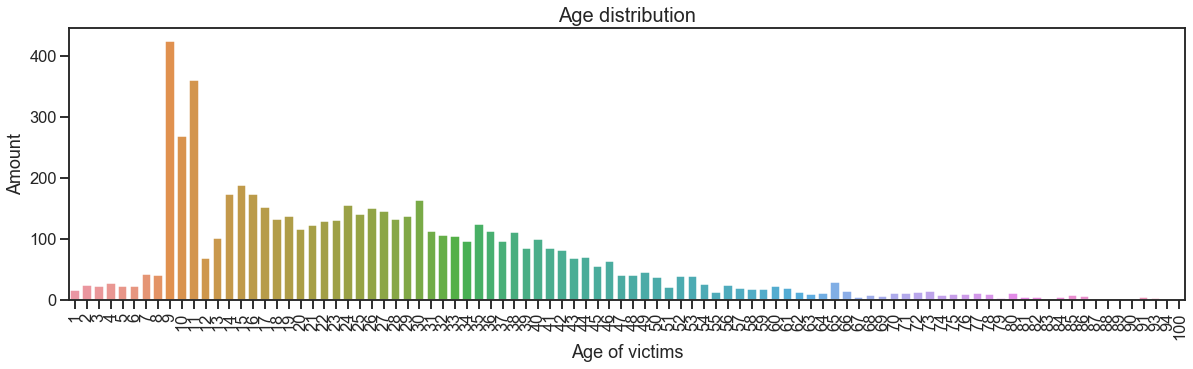

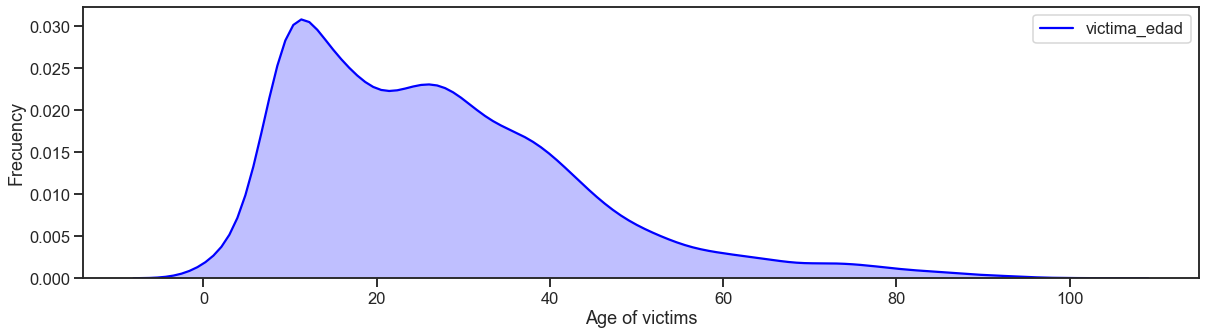

In [25]:
EDA.Graphs.BoxplotGender(X = df_svrg)
EDA.Graphs.AgePlot2(X = df_svrg)

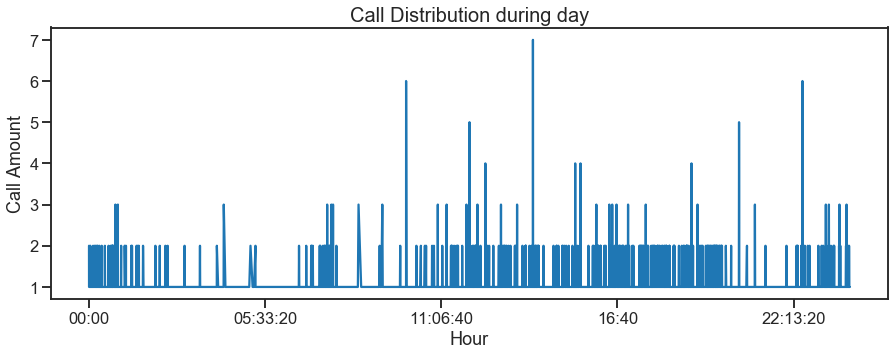

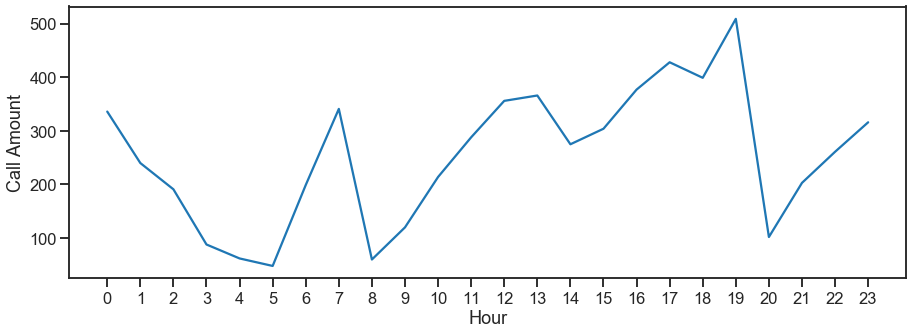

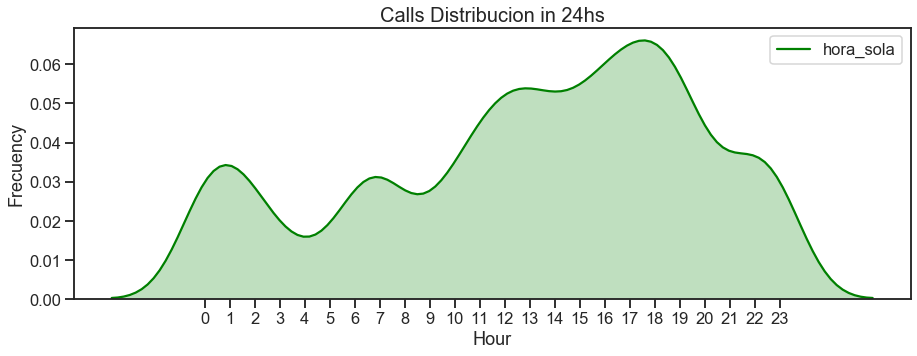

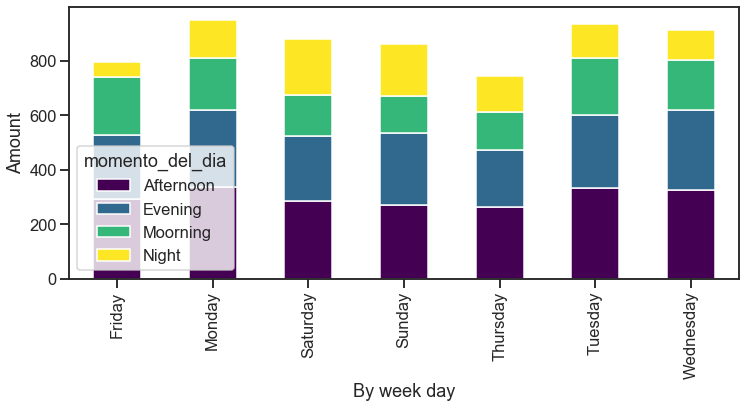

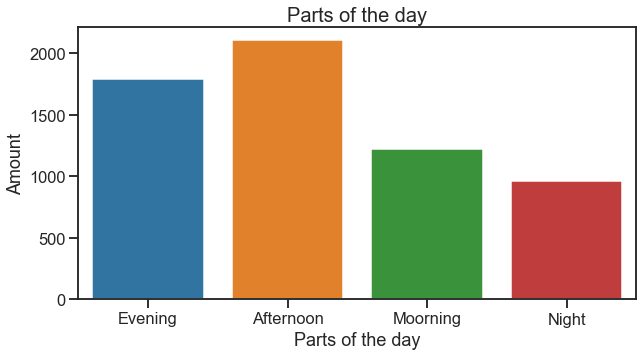

In [26]:
EDA.Graphs.TimePlot(X = df_svrg)
EDA.Graphs.WeekdayPlot(X = df_svrg)
EDA.Graphs.DaytimePlot(X = df_svrg)

# Conclusions of the regression models

The conclusion reached, after testing 2 regression models are:

- The 'least error' model was the Gaussian SVR with Threshold Feature Selection, but even so, our feedback results showed it is clearly skewed or noisy. Its poor performance is noted visually in the age distribution curve, a clear sign that it is not optimal.

- On the other hand, the KNN model with Lasso, which although it did not have the best performance based on errors, has the best curves and histograms at a visual level. This was an indicator of acceptable performance, which can be seen when looking at the age distribution curve when feedback is applied.

# Lets try to predict how the call ended. With intervention of authorities or without

In [33]:
lavf_preselectionC = LD.ClassificationModels(df)

In [34]:
lavf_preselectionC = ML.LabelEncoding2(X = lavf_preselectionC)

In [35]:
xtrain_scal_lasso2, xtrain_scal_rfe2, xtest_scal_lasso2, ytrain2, ytest2 = ML.FSelection2(lavf_preselectionC)

In [36]:
fpr1, tpr1, auc_knn_l_cl, ypred_knn_test_l_cl = ML.KNN_Lasso2(xtrain_scal_lasso2, xtest_scal_lasso2, ytrain2, ytest2)

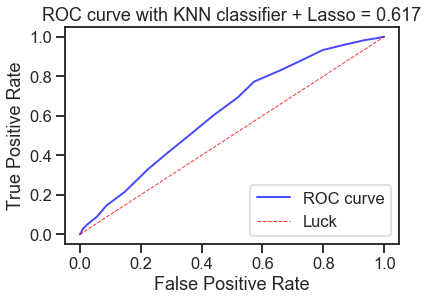

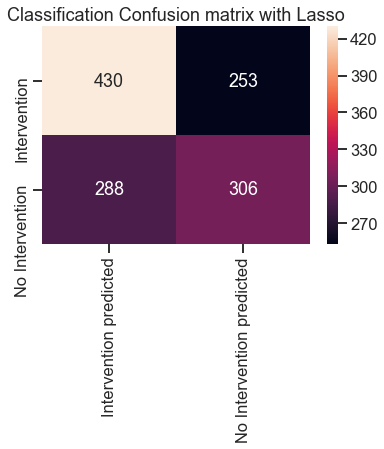

In [37]:
EDA.Graphs.ROC_KNN_Lasso(fpr1, tpr1, auc_knn_l_cl)
EDA.Graphs.ConfussionMatrix_KNN_Lasso(ytest2, ypred_knn_test_l_cl)

In [38]:
fpr2, tpr2, auc_svm_l, ypred_svm_test = ML.SVM_Lasso(xtrain_scal_lasso2, xtest_scal_lasso2, ytrain2, ytest2)

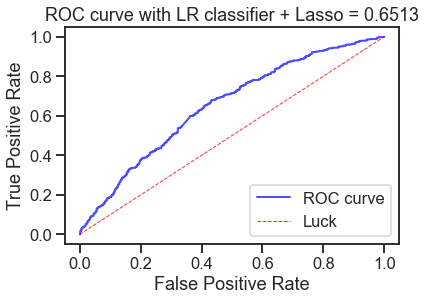

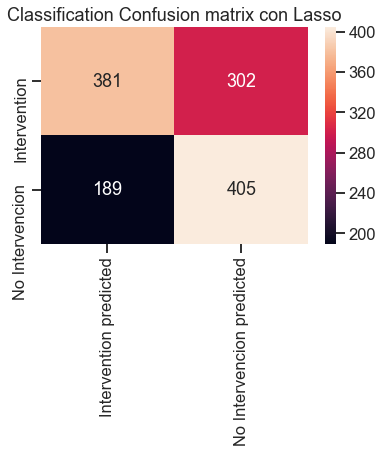

In [39]:
EDA.Graphs.ROC_SVM_Lasso(fpr2, tpr2, auc_svm_l)
EDA.Graphs.ConfussionMatrix_SVM_Lasso(ytest2, ypred_svm_test)

### Classification Conclusions
Analyzing the AUC ROC curve and the Confusion Matrix:
It is not possible, at least for the moment and under the implemented methodology, to apply classification models. Due to its large margin of error, just over 0.5 according to AUC ROC

# Proyect conclusions
From the available csv, techniques, methods and tools that we currently have, we come to the conclusion that a classification model is not optimal in these circumstances.

On the other hand, we were able to feed back the final dataset obtained with previously discarded samples whose 'victim age' field was without data but the rest of the features were complete.
In other words, we were able to some extent to take advantage of discarded data in the filter and cleaning to nurture the project.

Reaching an acceptable result and demonstrating that the model with the least error is not always the best option. Since you have to understand how the models work mathematically and understand the nature of the problem that one is facing